In [1]:
# general tools
import sys
from glob import glob
from datetime import datetime, timedelta

# data tools
import h5py
import pygrib
import pickle
import numpy as np
import pandas as pd
import netCDF4 as nc

# stats tools
from skgstat import Variogram
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.stats import pearsonr, spearmanr

# ANN tools
from tensorflow import keras

# graph tools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import matplotlib.path as path

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# custom tools
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/DL_downscaling/')
from namelist import *
import data_utils as du
import graph_utils as gu
import verif_utils as vu
import model_utils as mu
import train_utils as tu

In [2]:
%matplotlib inline

In [13]:
gfs_files = sorted(glob(GFS_dir + 'originals/*.grb2'))[:-1]

In [14]:
gfs_files

['/glade/scratch/ksha/BACKUP/GFS/originals/gfs_3_20191230_0000_024.grb2',
 '/glade/scratch/ksha/BACKUP/GFS/originals/gfs_3_20191230_0000_027.grb2',
 '/glade/scratch/ksha/BACKUP/GFS/originals/gfs_3_20191230_0000_030.grb2',
 '/glade/scratch/ksha/BACKUP/GFS/originals/gfs_3_20191230_0000_033.grb2',
 '/glade/scratch/ksha/BACKUP/GFS/originals/gfs_3_20191230_0000_036.grb2',
 '/glade/scratch/ksha/BACKUP/GFS/originals/gfs_3_20191230_0000_039.grb2',
 '/glade/scratch/ksha/BACKUP/GFS/originals/gfs_3_20191230_0000_042.grb2',
 '/glade/scratch/ksha/BACKUP/GFS/originals/gfs_3_20191230_0000_045.grb2']

In [9]:
with pygrib.open(gfs_files[0]) as grbs:
    var_table = list(grbs.select())
    TMEAN = grbs.select()[434].values[...] # 56 for cmc
    lat, lon = grbs.select()[434].latlons()

In [18]:
temp_t = np.zeros([8, 181, 360])

for i in range(8):
    with pygrib.open(gfs_files[i]) as grbs:
        temp_t[i, ...] = grbs.select()[434].values[...]
        
gfs_raw = np.flipud(np.nanmean(temp_t, 0))
gfs_raw = gfs_raw - 273.15 

In [38]:
with pygrib.open(gfs_files[0]) as grbs:
    lat, lon = grbs.select()[434].latlons()
lat = np.flipud(lat)
#lon[lon>180] = lon[lon>180]-360

## CGAN

In [24]:
with h5py.File(PRISM_dir+'land_mask_NA.hdf', 'r') as hdf_io:
    lon_4km = hdf_io['lon_4km'][...]
    lat_4km = hdf_io['lat_4km'][...]
    lon_025 = hdf_io['lon_025'][...]
    lat_025 = hdf_io['lat_025'][...]
    land_mask = hdf_io['land_mask'][...]
    etopo_4km = hdf_io['etopo_4km'][...]
    etopo_regrid = hdf_io['etopo_regrid'][...]

In [25]:
model_import_dir = temp_dir
CGAN = keras.models.load_model(model_import_dir+'Cycle-GAN_TMEAN_LR.hdf')

In [26]:
param = {}
param['gap'] = 22
param['edge'] = 44
param['size'] = 96

In [28]:
TMEAN_REGRID = du.interp2d_wraper(lon, lat, gfs_raw, lon_4km, lat_4km, method=interp_method)

In [30]:
X = (TMEAN_REGRID, etopo_regrid)
temp_unet = vu.pred_domain(X, land_mask, CGAN, param, method='norm_std')
temp_025 = du.interp2d_wraper(lon_4km, lat_4km, temp_unet, lon_025, lat_025, method=interp_method)
temp_4km = du.interp2d_wraper(lon_025, lat_025, temp_025, lon_4km, lat_4km, method=interp_method)

/glade/u/home/ksha/WORKSPACE/DL_downscaling/utils/verif_utils.py:107: RuntimeWarning: invalid value encountered in greater
  flag_effective = np.logical_and(~np.isnan(temp_data[..., 0]), np.abs(temp_data[..., 0])>0)


## UNet

In [31]:
param = {}
param['gap'] = 16
param['edge'] = 32
param['size'] = 96

In [32]:
unet = keras.models.load_model(model_import_dir+'UNET3_TMEAN_djf_tune.hdf')

In [33]:
X_4km = (temp_4km, etopo_4km, etopo_regrid)
final_out = vu.pred_domain(X_4km, land_mask, unet, param, method='norm_std')

In [39]:
data_save = (lon_4km, lat_4km, lon_025, lat_025, lon, lat, gfs_raw, temp_025, final_out)
label_save = ['lon_4km', 'lat_4km', 'lon_025', 'lat_025', 'lon_gfs', 'lat_gfs', 'TMEAN_GFS', 'TMEAN_clean', 'TMEAN_4km']
du.save_hdf5(data_save, label_save, save_dir, 'GFS_single_test.hdf')

Save to /glade/work/ksha/data/Keras/PRISM_publish/GFS_single_test.hdf


In [34]:
# Cartopy map settings
scale_param = '10m' # 10m for publication quality
# US states and CAN-US boundary
PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

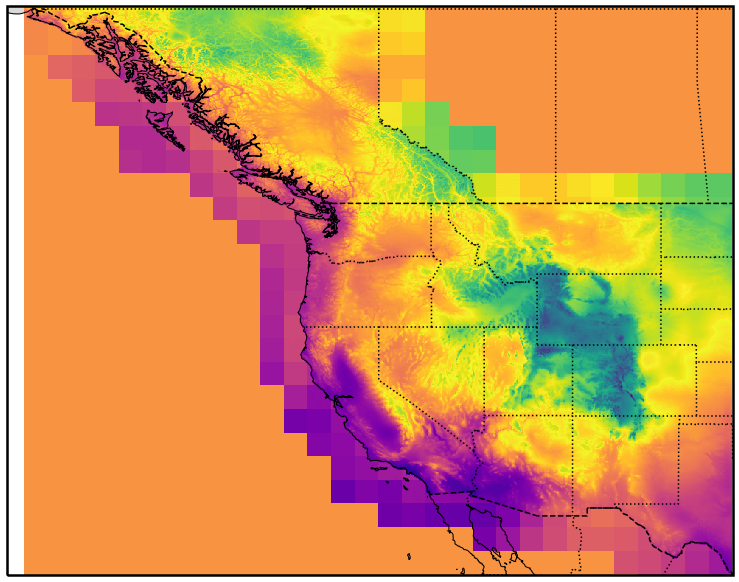

In [35]:
fig = plt.figure(figsize=(13, 13))
ax_base = fig.gca(projection=ccrs.PlateCarree())
ax_base.set_extent([-141, -100, 28, 58.5], ccrs.Geodetic())
ax_base.add_feature(cfeature.LAND.with_scale(scale_param), facecolor='0.85')
ax_base.add_feature(cfeature.COASTLINE.with_scale(scale_param), zorder=1.5)
ax_base.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='--', linewidth=1.5)
ax_base.add_feature(PROVINCE, edgecolor='k', linestyle=':', linewidth=1.5, zorder=1.5)
ax_base.outline_patch.set_linewidth(2.5)
ax_base.pcolormesh(lon_4km, lat_4km, final_out, vmin=-25, vmax=15, cmap=gu.cmap_combine(plt.cm.viridis, plt.cm.plasma_r))